In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, colormaps
import ipywidgets

In [7]:
# Give initial parameters to generate the probe
pixel_size = 0.1 # All units are in angstroms for computational simulations
im_shape = (512,512) # Pixel array size
probe_mrads = 20 # Max alpha
wavl = 0.02 # Wavelength (angstroms) Corresponds to ~300keV


In [8]:
# Make the coordinates
# Coordinates
kx = np.fft.fftfreq(im_shape[0], pixel_size) # Creates a frequency array scaled to the inverse of the real value passed
ky = np.fft.fftfreq(im_shape[1], pixel_size) # Creates a frequency array scaled to the inverse of the real value passed
kr2 = kx[:,None]**2+ky[None,:]**2
kr = kr2**0.5

# Probe
k_max = probe_mrads/1000/wavl
# Psi0 = kr < k_max
Psi0 = np.clip((k_max-kr)/(kx[1]-kx[0])+0.5,0,1)


psi0 = np.fft.ifft2(Psi0)
# defocus = 
print(k_max)

1.0


In [9]:
def genMaskF(shape,f):
    x = np.arange(shape[0])
    y = np.arange(shape[1])
    
    
    # Create Mask
    return np.logical_and(
        np.mod(x[:,None],f) == 0,
        np.mod(y[None,:],f) == 0,
    )

In [164]:
# Get Array of Coordinates
def generateSpiralCoordinateArray(mask, fftShift = False):
    # Calculate the radius of the points
    arraySize = np.shape(mask)
    mask[np.where(mask>0)] = 1
    # Create a spiral ordering to apply to the masked points
    x = np.linspace(-arraySize[0]/2,arraySize[0]/2,arraySize[0])
    y = np.linspace(-arraySize[1]/2,arraySize[1]/2,arraySize[1])
    r = np.sqrt(x[:,None]**2+y[None,:]**2)
    angle = np.arctan2(x[:,None],y[None,:])
    
    # Apply the spiral to the mask
    if fftShift == True:
        spiral = mask*np.fft.fftshift(r+angle+0.5)
    else:
        spiral = mask*(r+angle+0.5)
    
    plt.imshow(np.real(spiral),cmap="jet")
    plt.colorbar()
    plt.xlim(im_shape[0]/2-64,im_shape[0]/2+64)
    plt.ylim(im_shape[1]/2-64,im_shape[1]/2+64)
    plt.show()
    # Sort the indices from lowest to highest
    ind = np.unravel_index(np.argsort(spiral, axis=None), spiral.shape)
    
    # Grab the location of the last non-zero value going back to front
    i = -1
    nonZero = True
    while nonZero == True: 
        sortedVal = spiral[ind[0][i]][ind[1][i]]
        
        if sortedVal == 0.0:
            nonZero = False
            i += 1
        elif i < -len(ind[0]):
            nonZero = False
        else:
            i -= 1
    
    # Return the final indices array
    x,y = ind
    return [x[i:],y[i:]]

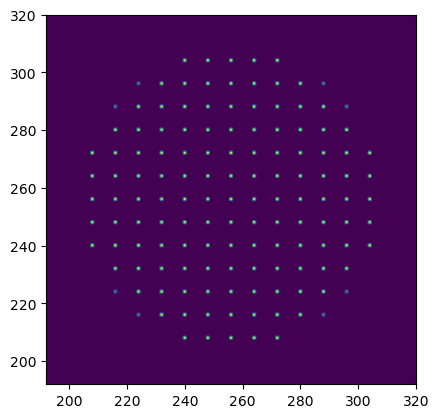

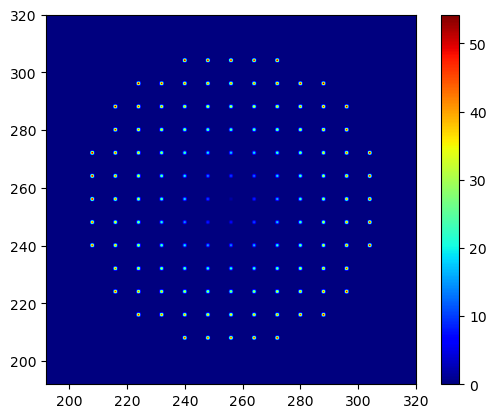

In [171]:
f = 8
Psi0downsampled = genMaskF(np.shape(Psi0),f)*Psi0

plt.imshow(np.fft.fftshift(Psi0downsampled))
plt.xlim(im_shape[0]/2-64,im_shape[0]/2+64)
plt.ylim(im_shape[1]/2-64,im_shape[1]/2+64)
plt.show()
spiralCoords = generateSpiralCoordinateArray(np.fft.fftshift(Psi0downsampled),False)


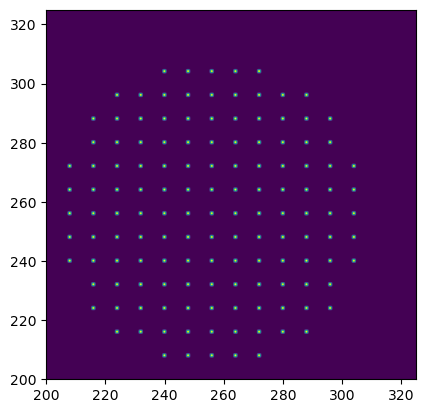

In [172]:
a = np.zeros(np.shape(Psi0downsampled))
for i in range(len(spiralCoords[0])):
    a[spiralCoords[0][i]][spiralCoords[1][i]] = 1
    
plt.imshow(a)
plt.xlim(200,325)
plt.ylim(200,325)
plt.show()

In [173]:
def genSpatialFrequencyArray(sampledPupil,coordinates = False):
    h,w = np.shape(sampledPupil)
    
    if coordinates:
        x,y = coordinates
    else:
        x,y = np.where(sampledPupil>0)
        
    planeWaveStack = np.zeros((len(x),h,w),np.complex128)
    array = np.zeros((h,w))
    for i,coords in enumerate(zip(x,y)):
        xCord, yCord = coords
        array *= 0
        array[xCord,yCord] = 1
        if coordinates:
            planeWaveStack[i,:,:] = np.fft.ifft2(np.fft.ifftshift(array))
        else:
            planeWaveStack[i,:,:] = np.fft.ifft2(array)
    return planeWaveStack



planeWaveStack = genSpatialFrequencyArray(Psi0downsampled, spiralCoords)

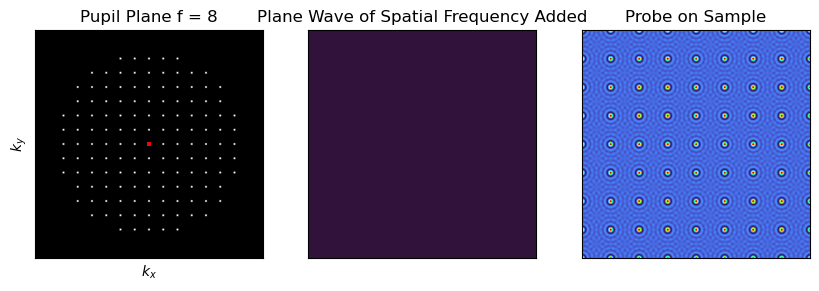

In [170]:
image_array = planeWaveStack
coords = spiralCoords
# Create the figure and axis
probeTotal = np.zeros(np.shape(Psi0downsampled),dtype=np.complex128)
pupilTotal = np.zeros(np.shape(Psi0downsampled))
fig, ax = plt.subplots(1,3,figsize=(10,3.5))
ax1,ax2,ax3 = ax
# Update function for animation
def update(frame):
    # Make a display of where each spatial frequency came
    if frame >= len(image_array):
        pass
    else:
        global pupilTotal
        pupilTotal[(coords[0][frame], coords[1][frame])] = np.nan
        cmap = colormaps.get_cmap('gray')
        cmap.set_bad("red")
        ax1.clear()
        ax1.imshow(pupilTotal, cmap=cmap)
        ax1.set_title(f"Pupil Plane f = 8")
        ax1.set_xlim(im_shape[0]/2-64,im_shape[0]/2+64)
        ax1.set_ylim(im_shape[1]/2-64,im_shape[1]/2+64)
        ax1.set_ylabel("$k_{y}$")
        ax1.set_xlabel("$k_{x}$")
        ax1.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False) 
        # print(f"{coords[0][frame]}, {coords[1][frame]} ")
        
        ax2.clear()
        ax2.imshow(np.real(image_array[frame]), cmap='turbo')
        ax2.set_title(f"Plane Wave of Spatial Frequency Added")
        ax2.set_xlim(0,im_shape[0])
        ax2.set_ylim(1,im_shape[0])
        ax2.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False) 
        
        # Add the probe to the total
        global probeTotal 
        probeTotal += image_array[frame]
        ax3.clear()
        ax3.imshow(np.real(probeTotal), cmap='turbo')
        ax3.set_title(f"Probe on Sample")
        ax3.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False) 
        if frame >= len(image_array)/4:
            ax3.set_title(f"Zoomed in Probe on Sample")
            ax3.set_xlim(im_shape[0]/2-64,im_shape[0]/2+64)
            ax3.set_ylim(im_shape[1]/2-64,im_shape[1]/2+64)
        pupilTotal[(coords[0][frame], coords[1][frame])] = 1
    return ax,

# Create the animation
anim = animation.FuncAnimation(fig, update, frames=len(image_array)+10, interval=200, blit=False)

# Save the animation as a GIF
anim.save('probe_construction.gif', writer='pillow', fps=4)

(2, 137)


In [12]:
# fig.savefig("static_spatial_frequency_sampling.png")

# F Sampling Widget

In [13]:
# Spatial Frequencies Displayed

def wrapper_function(f):
    Psi0downsampled = genMaskF(np.shape(Psi0),f)*Psi0

    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(8,6)
    ax1,ax2 = ax
    ax1.imshow(np.fft.ifftshift(Psi0downsampled))
    ax1.set_title(f"Pupil Plane")
    ax1.set_ylabel("$k_{y}$")
    ax1.set_xlabel("$k_{x}$")
    ax1.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False) 
    ax1.set_xlim((512/2-64,512/2+64))
    ax1.set_ylim((512/2-64,512/2+64))


    ax2.clear()
    ax2.imshow(np.real(np.fft.ifftshift(np.fft.ifft2(Psi0downsampled))), cmap='turbo')
    ax2.set_title(f"Probe on Sample")
    ax2.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False) 
    ax2.set_ylabel("y (arb units)")
    ax2.set_xlabel("x (arb units)")
    # ax2.set_xlim((512/2-64,512/2+64))
    # ax2.set_ylim((512/2-64,512/2+64))
    
    return None